In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Concatenate, Bidirectional, RepeatVector, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split

seed_value = 42
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [2]:
data = pd.read_csv('telcox.csv')

## 1. Preprocessing and Data Preparation

In [3]:
N_UNIQUE_ACTS = len(data['activity'].unique()) + 1 

data['start'] = pd.to_datetime(data['start'])
data['end'] = pd.to_datetime(data['end'])

exclude_columns = ["traceId", "index", "activity", "start", "end", "duration", "EVENTID", "VariantId"]

attributes = data.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()
selected_attributes = [attr for attr in attributes if attr not in exclude_columns]

In [4]:
data['activity_list'] = data.groupby('traceId')['activity'].transform(lambda x: [x.tolist()] * len(x))
data['activity_durations'] = data.groupby('traceId')['duration'].transform(lambda x: [x.tolist()] * len(x))

data['next_activity'] = data.groupby('traceId')['activity'].shift(-1)
data['next_start'] = data.groupby('traceId')['start'].shift(-1)

data['transition_duration'] = (data['next_start'] - data['end']).dt.total_seconds().fillna(0).astype(int)
data['transition_durations'] = data.groupby('traceId')['transition_duration'].transform(lambda x: [x.tolist()] * len(x))

data['total_duration'] = data.groupby('traceId')['duration'].transform('sum') + data.groupby('traceId')['transition_duration'].transform('sum')

In [5]:
activity_tokenizer = Tokenizer(filters='', lower=False, split='Ω')
activity_tokenizer.fit_on_texts(data['activity'].unique().tolist())

data['activity_tokenized'] = [seq[0] for seq in activity_tokenizer.texts_to_sequences(data['activity'])]
data['sequence_tokenized'] = activity_tokenizer.texts_to_sequences(data['activity_list'])
data['next_activity_tokenized'] = [seq[0] if seq else -1 for seq in activity_tokenizer.texts_to_sequences(data['next_activity'].fillna('UNKNOWN'))]
data['tokenized_transition'] = data['activity_tokenized'].astype(str) + "->" + data['next_activity_tokenized'].astype(str)

attribute_tokenizers = {}
for attr in selected_attributes:
    tok = Tokenizer(filters='', lower=False, split='Ω')
    tok.fit_on_texts(data[attr].astype(str).tolist())
    sequences = tok.texts_to_sequences(data[attr].astype(str).tolist())
    data[attr] = [seq[0] if seq else -1 for seq in sequences]
    attribute_tokenizers[attr] = tok

In [6]:
data_sequences = data.drop_duplicates(subset='traceId')[['traceId', 'sequence_tokenized', 'activity_durations', 'transition_durations', 'total_duration'] + selected_attributes]

In [7]:
data_sequences

,traceId,sequence_tokenized,activity_durations,transition_durations,total_duration,CCgroup,Center,Contractores,FSresult,OpenWO,Type
0,01be9719-6b2f-4200-b72c-54d085f8af1c,"[1, 2, 3, 4, 5]","[54, 50, 188, 110, 57]","[0, 0, 0, 21256, 0]",21715,3,2,3,1,2,1
5,060404a8-6ef2-4bdf-a489-146940182867,"[1, 2, 3, 6, 7, 8, 9, 10, 5]","[54, 2, 95, 19, 4, 80, 1133, 108, 38]","[1707, 87, 3478, 130716, 86200, 98240, 403, 12...",334658,2,1,1,3,1,1
14,061b22a0-9f97-4871-9b02-814d531e25e7,"[1, 2, 3, 6, 7, 8, 9, 10, 5]","[56, 8, 175, 75, 52, 25, 4827, 1, 4]","[417, 795, 3500, 111103, 95248, 98014, 267, 24...",338900,3,1,1,1,1,1
23,07a10e2c-c356-405a-bb71-62122ae3efa3,"[1, 2, 3, 6, 7, 8, 9, 10, 5]","[53, 15, 60, 46, 138, 92, 2028, 77, 59]","[1540, 189, 3547, 128811, 91879, 81325, 189, 2...",337447,3,1,1,1,1,1
32,0c5ae66d-e82b-447d-9bc5-b46f52419a5b,"[1, 2, 3, 6, 7, 8, 9, 10, 5]","[33, 69, 103, 162, 170, 43, 428, 92, 39]","[1278, 2594, 3159, 48364, 80125, 77068, 247, 1...",229530,2,1,3,4,1,4
...,...,...,...,...,...,...,...,...,...,...,...
32365,d9efc47d-e780-4afe-b87f-2259fad5887e,"[1, 2, 3, 6, 7, 8, 9, 10, 5]","[55, 29, 262, 166, 77, 49, 5246, 27, 17]","[3338, 1567, 0, 43332, 69515, 97379, 768, 1536...",237187,1,1,1,4,1,4
32374,dd53abfa-5cae-4245-88d6-322b191a9795,"[1, 2, 3, 4, 5]","[16, 115, 289, 82, 40]","[0, 0, 0, 20546, 0]",21088,2,1,2,1,5,1
32379,f13ad972-12ba-4602-ab09-b140750e6398,"[1, 2, 3, 6, 7, 8, 9, 10, 5]","[9, 37, 159, 96, 15, 103, 2436, 76, 45]","[1229, 259, 166, 109720, 69260, 91271, 1, 2275...",297637,1,2,1,4,1,1
32388,fecd9b3e-903c-4d20-a8da-9e99f6d62921,"[1, 2, 3, 6, 7, 8, 9, 10, 5]","[15, 82, 141, 163, 169, 7, 5276, 98, 17]","[2426, 714, 102, 50346, 67915, 82830, 420, 217...",232451,1,2,2,6,1,4


In [8]:
def truncate_sequence(seq):
    if len(seq) > 1:
        trunc_point = np.random.randint(1, len(seq))
        truncated = seq[:trunc_point]
        remaining = seq[trunc_point:]
    else:
        truncated = seq
        remaining = []
        trunc_point = len(seq)
    return truncated, remaining, trunc_point

def truncate_list(lst, trunc_points, offset=0):
    truncated = [item[:tp - offset] for item, tp in zip(lst, trunc_points)]
    remaining = [item[tp - offset:] for item, tp in zip(lst, trunc_points)]
    return truncated, remaining

data_sequences[['truncated_tokenized', 'remaining_tokenized', 'trunc_point']] = data_sequences['sequence_tokenized'].apply(truncate_sequence).apply(pd.Series)

data_sequences['truncated_durations'], data_sequences['remaining_durations'] = truncate_list(data_sequences['activity_durations'], data_sequences['trunc_point'])
data_sequences['truncated_transitions'], data_sequences['remaining_transitions'] = truncate_list(data_sequences['transition_durations'], data_sequences['trunc_point'], 1)

data_sequences['truncated_total_duration'] = data_sequences['truncated_durations'].apply(sum) + data_sequences['truncated_transitions'].apply(sum)
data_sequences['remaining_total_duration'] = data_sequences['remaining_durations'].apply(sum) + data_sequences['remaining_transitions'].apply(sum)

assert all(data_sequences['truncated_total_duration'] + data_sequences['remaining_total_duration'] == data_sequences['total_duration'])


In [9]:
MAX_SEQ_LENGTH = max(data_sequences['sequence_tokenized'].apply(len))
data_sequences['truncated_tokenized'] = pad_sequences(data_sequences['truncated_tokenized'], maxlen=MAX_SEQ_LENGTH, padding='post').tolist()
data_sequences['remaining_tokenized'] = pad_sequences(data_sequences['remaining_tokenized'], maxlen=MAX_SEQ_LENGTH, padding='post').tolist()

In [10]:
data_sequences

,traceId,sequence_tokenized,activity_durations,transition_durations,total_duration,CCgroup,Center,Contractores,FSresult,OpenWO,Type,truncated_tokenized,remaining_tokenized,trunc_point,truncated_durations,remaining_durations,truncated_transitions,remaining_transitions,truncated_total_duration,remaining_total_duration
0,01be9719-6b2f-4200-b72c-54d085f8af1c,"[1, 2, 3, 4, 5]","[54, 50, 188, 110, 57]","[0, 0, 0, 21256, 0]",21715,3,2,3,1,2,1,"[1, 2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[4, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",3,"[54, 50, 188]","[110, 57]","[0, 0]","[0, 21256, 0]",292,21423
5,060404a8-6ef2-4bdf-a489-146940182867,"[1, 2, 3, 6, 7, 8, 9, 10, 5]","[54, 2, 95, 19, 4, 80, 1133, 108, 38]","[1707, 87, 3478, 130716, 86200, 98240, 403, 12...",334658,2,1,1,3,1,1,"[1, 2, 3, 6, 0, 0, 0, 0, 0, 0, 0, 0]","[7, 8, 9, 10, 5, 0, 0, 0, 0, 0, 0, 0]",4,"[54, 2, 95, 19]","[4, 80, 1133, 108, 38]","[1707, 87, 3478]","[130716, 86200, 98240, 403, 12294, 0]",5442,329216
14,061b22a0-9f97-4871-9b02-814d531e25e7,"[1, 2, 3, 6, 7, 8, 9, 10, 5]","[56, 8, 175, 75, 52, 25, 4827, 1, 4]","[417, 795, 3500, 111103, 95248, 98014, 267, 24...",338900,3,1,1,1,1,1,"[1, 2, 3, 6, 7, 0, 0, 0, 0, 0, 0, 0]","[8, 9, 10, 5, 0, 0, 0, 0, 0, 0, 0, 0]",5,"[56, 8, 175, 75, 52]","[25, 4827, 1, 4]","[417, 795, 3500, 111103]","[95248, 98014, 267, 24333, 0]",116181,222719
23,07a10e2c-c356-405a-bb71-62122ae3efa3,"[1, 2, 3, 6, 7, 8, 9, 10, 5]","[53, 15, 60, 46, 138, 92, 2028, 77, 59]","[1540, 189, 3547, 128811, 91879, 81325, 189, 2...",337447,3,1,1,1,1,1,"[1, 2, 3, 6, 7, 8, 9, 0, 0, 0, 0, 0]","[10, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",7,"[53, 15, 60, 46, 138, 92, 2028]","[77, 59]","[1540, 189, 3547, 128811, 91879, 81325]","[189, 27399, 0]",309723,27724
32,0c5ae66d-e82b-447d-9bc5-b46f52419a5b,"[1, 2, 3, 6, 7, 8, 9, 10, 5]","[33, 69, 103, 162, 170, 43, 428, 92, 39]","[1278, 2594, 3159, 48364, 80125, 77068, 247, 1...",229530,2,1,3,4,1,4,"[1, 2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[6, 7, 8, 9, 10, 5, 0, 0, 0, 0, 0, 0]",3,"[33, 69, 103]","[162, 170, 43, 428, 92, 39]","[1278, 2594]","[3159, 48364, 80125, 77068, 247, 15556, 0]",4077,225453
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32365,d9efc47d-e780-4afe-b87f-2259fad5887e,"[1, 2, 3, 6, 7, 8, 9, 10, 5]","[55, 29, 262, 166, 77, 49, 5246, 27, 17]","[3338, 1567, 0, 43332, 69515, 97379, 768, 1536...",237187,1,1,1,4,1,4,"[1, 2, 3, 6, 7, 8, 9, 0, 0, 0, 0, 0]","[10, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",7,"[55, 29, 262, 166, 77, 49, 5246]","[27, 17]","[3338, 1567, 0, 43332, 69515, 97379]","[768, 15360, 0]",221015,16172
32374,dd53abfa-5cae-4245-88d6-322b191a9795,"[1, 2, 3, 4, 5]","[16, 115, 289, 82, 40]","[0, 0, 0, 20546, 0]",21088,2,1,2,1,5,1,"[1, 2, 3, 4, 0, 0, 0, 0, 0, 0, 0, 0]","[5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",4,"[16, 115, 289, 82]",[40],"[0, 0, 0]","[20546, 0]",502,20586
32379,f13ad972-12ba-4602-ab09-b140750e6398,"[1, 2, 3, 6, 7, 8, 9, 10, 5]","[9, 37, 159, 96, 15, 103, 2436, 76, 45]","[1229, 259, 166, 109720, 69260, 91271, 1, 2275...",297637,1,2,1,4,1,1,"[1, 2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[6, 7, 8, 9, 10, 5, 0, 0, 0, 0, 0, 0]",3,"[9, 37, 159]","[96, 15, 103, 2436, 76, 45]","[1229, 259]","[166, 109720, 69260, 91271, 1, 22755, 0]",1693,295944
32388,fecd9b3e-903c-4d20-a8da-9e99f6d62921,"[1, 2, 3, 6, 7, 8, 9, 10, 5]","[15, 82, 141, 163, 169, 7, 5276, 98, 17]","[2426, 714, 102, 50346, 67915, 82830, 420, 217...",232451,1,2,2,6,1,4,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[2, 3, 6, 7, 8, 9, 10, 5, 0, 0, 0, 0]",1,[15],"[82, 141, 163, 169, 7, 5276, 98, 17]",[],"[2426, 714, 102, 50346, 67915, 82830, 420, 217...",15,232436


## 2. Data Splitting
- **Training Set:** 80% of the unique traces.
- **Testing Set:** The remaining 20%.

In [11]:
train_df, test_df = train_test_split(data_sequences, test_size=0.2, random_state=42)

train_df = train_df.sort_values(by='traceId')
test_df = test_df.sort_values(by='traceId')

X_train_features = train_df[selected_attributes].values
X_test_features = test_df[selected_attributes].values

## 3. Data Reshaping and One-hot Encoding

In [12]:
X_train = np.array(train_df['truncated_tokenized'].tolist())
Y_train = np.array(train_df['remaining_tokenized'].tolist())

X_test = np.array(test_df['truncated_tokenized'].tolist())
Y_test = np.array(test_df['remaining_tokenized'].tolist())

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
Y_train = Y_train.reshape(Y_train.shape[0], Y_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
Y_test = Y_test.reshape(Y_test.shape[0], Y_test.shape[1], 1)

Y_train_onehot = to_categorical(Y_train.squeeze(), num_classes=N_UNIQUE_ACTS)
Y_test_onehot = to_categorical(Y_test.squeeze(), num_classes=N_UNIQUE_ACTS)

In [13]:
def mask_acc(y_true, y_pred):
    # Mask for the true values (not equal to 0)
    mask = K.cast(K.max(y_true, axis=-1), K.floatx())
    
    # Calculate accuracy for the positions where mask is 1 and true value is not zero
    y_true_labels = K.cast(K.argmax(y_true, axis=-1), K.floatx())
    y_pred_labels = K.cast(K.argmax(y_pred, axis=-1), K.floatx())
    
    # Exclude zero labels
    non_zero_mask = K.cast(K.greater(y_true_labels, 0), K.floatx())
    
    is_correct = K.cast(K.equal(y_true_labels, y_pred_labels), K.floatx()) * mask * non_zero_mask
    total_correct = K.sum(is_correct)
    total_values = K.sum(mask * non_zero_mask)
    
    return total_correct / total_values

def seq_acc(y_true, y_pred):
    # Convert predictions to label indices
    y_pred_labels = K.argmax(y_pred, axis=-1)
    y_true_labels = K.argmax(y_true, axis=-1)
    
    # Check if for each sample, the predicted sequence is equal to the true sequence
    correct_preds = K.all(K.equal(y_true_labels, y_pred_labels), axis=-1)
    
    # Compute the accuracy based on fully correct sequences
    accuracy = K.mean(correct_preds)
    return accuracy

## 4. Model Definition and Training

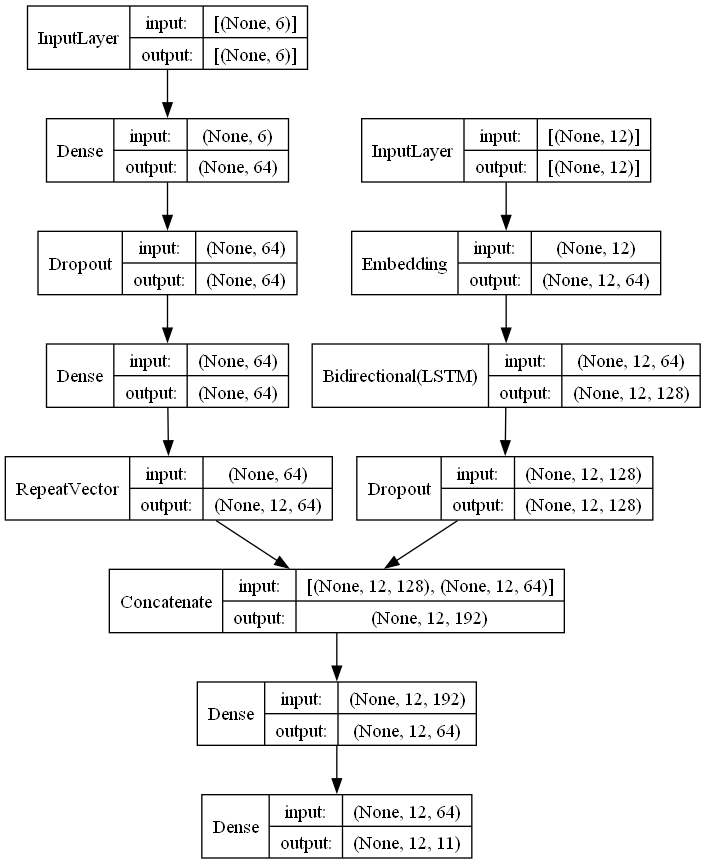

In [14]:
# 1. Sequence Input and Processing
sequence_input = Input(shape=(X_train.shape[1],))
embedded_sequences = Embedding(input_dim=N_UNIQUE_ACTS, output_dim=64)(sequence_input)
lstm_out = Bidirectional(LSTM(64, return_sequences=True))(embedded_sequences)
lstm_out = Dropout(0.15)(lstm_out)  # Add dropout after LSTM

# 2. Feature Input and Processing
feature_input = Input(shape=(X_train_features.shape[1],))
dense_feature = Dense(64, activation='relu')(feature_input)
dense_feature = Dropout(0.15)(dense_feature)  # Add dropout after first Dense layer
dense_feature = Dense(64, activation='relu')(dense_feature)
repeated_feature = RepeatVector(X_train.shape[1])(dense_feature) 

# 3. Combining the sequence and feature processing paths
concatenated = Concatenate(axis=-1)([lstm_out, repeated_feature])
combined_dense = Dense(64, activation='relu')(concatenated)

# 4. Output Layer
output = Dense(N_UNIQUE_ACTS, activation='softmax')(combined_dense)

# Create and compile the model
model = Model(inputs=[sequence_input, feature_input], outputs=output)
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.005), metrics=[mask_acc, seq_acc])

plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=False)

In [15]:
history = model.fit([X_train, X_train_features], 
                    Y_train_onehot, 
                    batch_size=32, 
                    epochs=10, 
                    validation_data=([X_test, X_test_features], Y_test_onehot))

Epoch 1/10
112/112 [==============================] - 3s 9ms/step - loss: 0.7522 - mask_acc: 0.2712 - seq_acc: 0.1642 - val_loss: 0.4339 - val_mask_acc: 0.5857 - val_seq_acc: 0.4818
Epoch 2/10
112/112 [==============================] - 1s 5ms/step - loss: 0.3906 - mask_acc: 0.6465 - seq_acc: 0.5432 - val_loss: 0.3033 - val_mask_acc: 0.7520 - val_seq_acc: 0.6784
Epoch 3/10
112/112 [==============================] - 1s 5ms/step - loss: 0.2996 - mask_acc: 0.7469 - seq_acc: 0.6650 - val_loss: 0.2461 - val_mask_acc: 0.7898 - val_seq_acc: 0.7414
Epoch 4/10
112/112 [==============================] - 1s 5ms/step - loss: 0.2433 - mask_acc: 0.8059 - seq_acc: 0.7437 - val_loss: 0.2062 - val_mask_acc: 0.8379 - val_seq_acc: 0.8286
Epoch 5/10
112/112 [==============================] - 1s 5ms/step - loss: 0.2319 - mask_acc: 0.8120 - seq_acc: 0.7322 - val_loss: 0.1991 - val_mask_acc: 0.8405 - val_seq_acc: 0.8342
Epoch 6/10
112/112 [==============================] - 1s 5ms/step - loss: 0.2163 - mask_ac

## 5. Model Evaluation

In [17]:
predicted_sequences1 = model.predict([X_train, X_train_features])
predicted_sequences2 = model.predict([X_test, X_test_features])

predicted_activity_indices1 = [np.argmax(seq, axis=-1) for seq in predicted_sequences1]
predicted_activity_indices2 = [np.argmax(seq, axis=-1) for seq in predicted_sequences2]

train_df['predicted_sequence'] = predicted_activity_indices1
test_df['predicted_sequence'] = predicted_activity_indices2

combined_df = pd.concat([train_df, test_df], axis=0).reset_index(drop=True)
combined_df = combined_df[['traceId', 'predicted_sequence']].copy()

def decode_token_sequence(token_sequence, tokenizer):
    return [tokenizer.index_word[token] for token in token_sequence if token in tokenizer.index_word]

combined_df['predicted_sequence'] = combined_df['predicted_sequence'].apply(lambda x: decode_token_sequence(x, activity_tokenizer))

28/28 [==============================] - 0s 2ms/step
